# Challenging functions

Ill-conditioned Hessians, flat regions, or local minima means `newton-raphson` might fail to converge efficiently.

Consider other [test functions for optimisation](https://en.wikipedia.org/wiki/Test_functions_for_optimization)



**Benchmarking Plan**

1. Examine contour plot to find a potential $\mathbf{x}_0$
2.  Make an suitable initial guess (by inspection)
3. Use both Newton–Raphson and Levenberg–Marquardt methods to test convergence and robustness.
4. Compare:
    - Number of iterations.
    - Accuracy of the minimiser.
    - Stability (e.g., did the method fail?).

In [1]:
%reset -f
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from Procedures.contour_plotting import (plot_contour, plot_clamped_contour,
                                         plot_surface)
from Classes.NewtonRaphson import NewtonRaphsonSolver
from Classes.LevenbergMarquardtTrustRegion import LevenbergMarquardtSolver

## Himmelblau’s Function

[Wikipedia](https://en.wikipedia.org/wiki/Himmelblau%27s_function)

Find a local minimum, to six decimal places, of the function

$$
f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2
$$

Challenges:

- Multiple minima require a robust method to handle poor starting points.
- Hessian becomes poorly conditioned near saddle points.

In [2]:
# Define the variables
x, y = sp.symbols('x y')
variables = [x, y]

# Define function
f = (x**2 + y- 11)**2 + (x + y**2 - 7)**2

# Lambdify for plotting
f_func = sp.lambdify(variables, f, 'numpy')

# Wrapper to reshape the input for SciPy
def f_scipy(x_array):
    return f_func(*x_array)  # Unpack array into variables

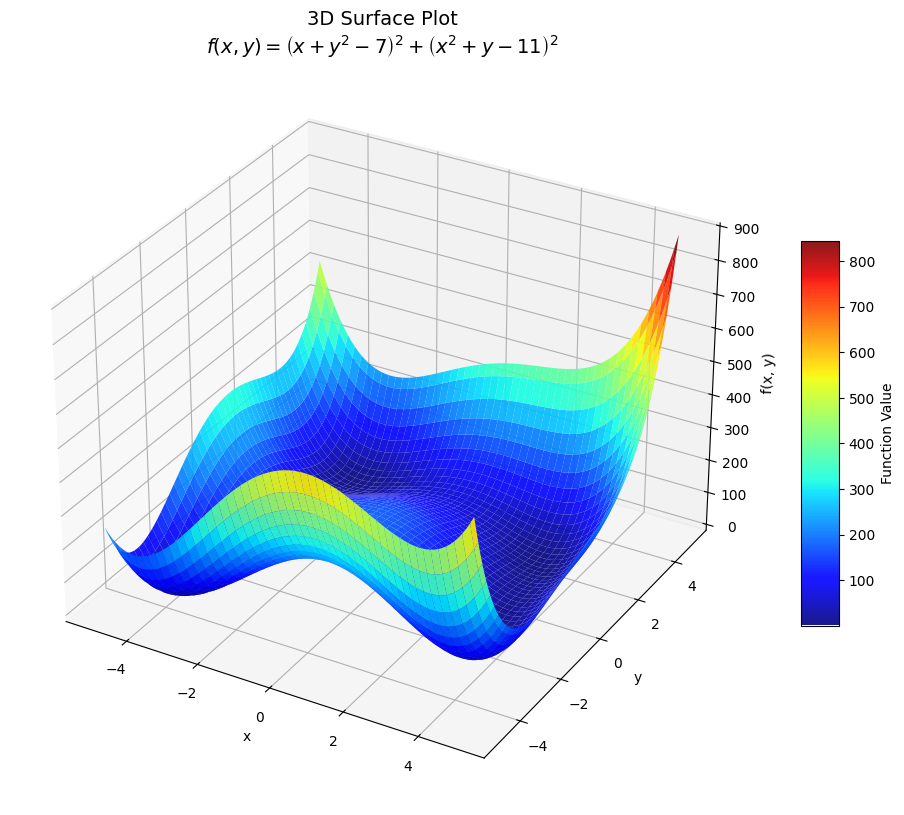

In [3]:
plot_surface(f_func, f, (-5, 5), (-5, 5), elev=30, azim=-60)

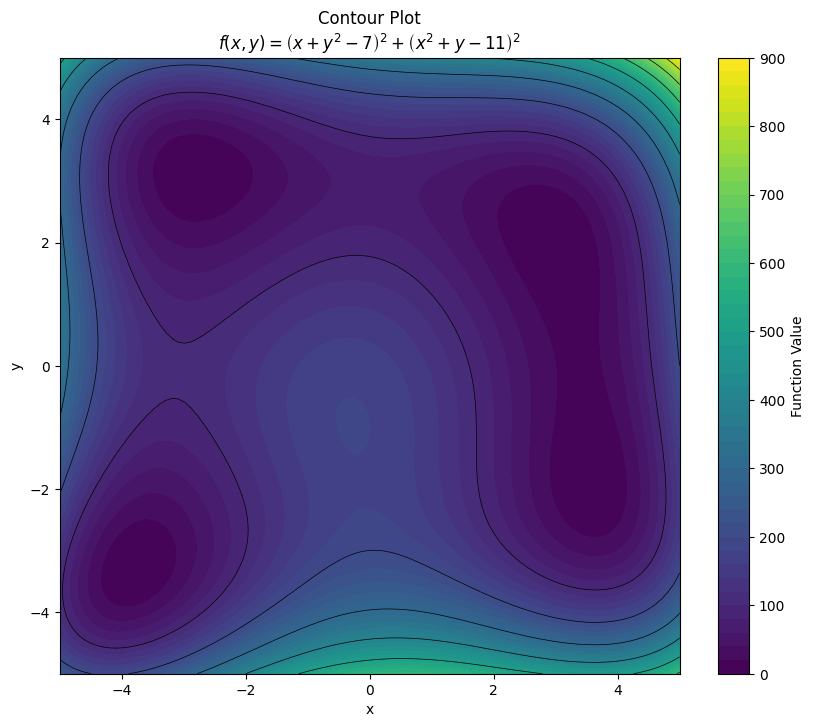

In [4]:
plot_contour(f_func, f, (-5, 5), (-5, 5))

It's crucial to choose an appropriate point $\mathbf{x}_0$ from the contour plot

In [5]:
# Initial point (chosen to not be a minimiser by inspection)
x0 = [0, 0]

In [6]:
# Test Levenberg-Marquardt
solver_lm = LevenbergMarquardtSolver(f, [x, y], x0)
result_lm = solver_lm.solve(verbose=False)
print("Levenberg-Marquardt Result:")
for key, value in result_lm.items():
    if key != "history":
        print(f"{key}: {value}")

# Test Newton-Raphson
solver_nr = NewtonRaphsonSolver(f, [x, y], x0)
result_nr = solver_nr.solve(verbose=False)
print("\nNewton-Raphson Result:")
for key, value in result_nr.items():
    if key != "history":
        print(f"{key}: {value}")

# Test BFGS
result_bfgs = minimize(f_scipy, x0, method='BFGS', tol=0.5e-5)
print("\nBFGS Result:")
for key in ['success', 'message', 'x', 'fun', 'nit', 'nfev']:
    print(f"{key}: {result_bfgs[key]}")

Levenberg-Marquardt Result:
success: True
reason: Converged within tolerances
x: [3.00000002 1.99999994]
fun: 4.867547681997086e-14
nit: 9
nfev: 10
lambda: 0.0021484375

Newton-Raphson Result:
success: True
message: Converged within tolerances
x: [3. 2.]
fun: 0.0
nit: 12
nfev: 13

BFGS Result:
success: True
message: Optimization terminated successfully.
x: [2.99999994 1.99999999]
fun: 1.3782249516558895e-13
nit: 10
nfev: 48


Newton–Raphson relies solely on the gradient and Hessian at each step, which can lead it to converge to saddle points or even diverge if the initial guess is not close to a true minimiser. In this case, it appears to have converged to a local saddle point instead of a global or local minimum.

$f_{\text{min}} = 181.62$ is far from zero.

In [7]:
print("Gradient")
display(solver_nr.gradient)

Gradient


Matrix([
[4*x*(x**2 + y - 11) + 2*x + 2*y**2 - 14],
[ 2*x**2 + 4*y*(x + y**2 - 7) + 2*y - 22]])

In [8]:
print("Hessian")
display(solver_lm.hessian)

Hessian


Matrix([
[2*(6*x**2 + 2*y - 21),             4*(x + y)],
[            4*(x + y), 2*(2*x + 6*y**2 - 13)]])

We now need to iterate over all 'close enough starting points' to find all the local minimisers with the Levenberg-Marquardt method.

In [9]:
# Starting points by inspection
start_points = [[-3, -3], [-3, 3], [4, 2], [4, -2]]

# Initialise list to store minimisers
minimisers = []

for point in start_points:
    solver_lm = LevenbergMarquardtSolver(f, [x, y], point)
    result_lm = solver_lm.solve(verbose=False)
    minimisers.append(result_lm['x'])

    print(f"\nPoint: {point}")
    for key, value in result_lm.items():
        if key != "history":
            print(f"{key}: {value}")


Point: [-3, -3]
success: True
reason: Converged within tolerances
x: [-3.77931022 -3.28318595]
fun: 1.0095039578358127e-13
nit: 8
nfev: 9
lambda: 0.004296875

Point: [-3, 3]
success: True
reason: Converged within tolerances
x: [-2.80511809  3.13131252]
fun: 5.073946973290571e-17
nit: 8
nfev: 9
lambda: 0.004296875

Point: [4, 2]
success: True
reason: Converged within tolerances
x: [3.00000001 1.99999997]
fun: 1.4339391479140733e-14
nit: 9
nfev: 10
lambda: 0.0021484375

Point: [4, -2]
success: True
reason: Converged within tolerances
x: [ 3.58442834 -1.84812655]
fun: 5.331519385327398e-15
nit: 9
nfev: 10
lambda: 0.0021484375


Local minima found. The number of iterations depends on how close the starting point is to the corresponding local minimum.

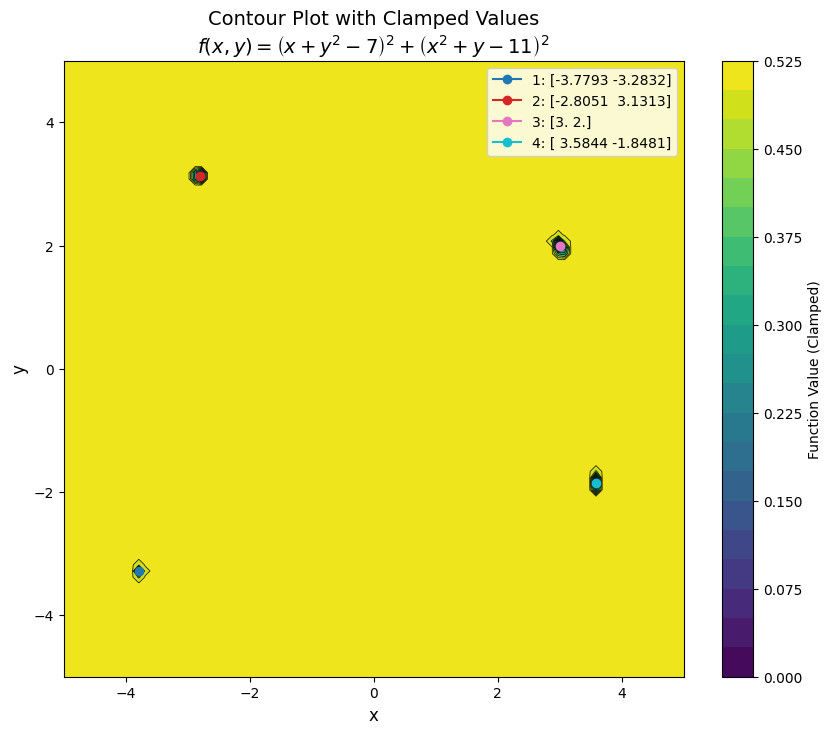

In [10]:
# Showing the minimisers on a clamped contour plot
plot_clamped_contour(f_func, f, (-5, 5), (-5, 5), minimisers=minimisers)

\newpage

## Powell's Singular Function

[Journal of Optimisation](https://optimization-online.org/wp-content/uploads/2012/03/3382.pdf)

A function with flat regions, leading to slow convergence:
$$
f(\mathbf{x}) = (x_1 + 10x_2)^2 + 5(x_3 - x_4)^2 + (x_2 - 2x_3)^4 + 10(x_1 - x_4)^4
$$

Challenges:

- Flat regions in the search space slow convergence.
- Gradient and Hessian can be misleading for the step direction.

In [11]:
# Define the variables
x_1, x_2, x_3, x_4 = sp.symbols('x_1 x_2 x_3 x_4')
variables = [x_1, x_2, x_3, x_4]

# Define function
f = (x_1 + 10*x_2)**2 + 5*(x_3 - x_4)**2 + (x_2 - 2*x_3)**4 + 10*(x_1 - x_4)**4
# Lambdify
f_func = sp.lambdify(variables, f, 'numpy')

# Wrapper to reshape the input for SciPy
def f_scipy(x_array):
    return f_func(*x_array)  # Unpack array into variables

$f(\mathbf{x})=f(x_1, x_2, x_3, x_4)$

In [12]:
# Here we have a n=4 variable function so contour plot unavailable
# Choose the standard starting point
x0 = [3, -1, 0, 1]

In [13]:
# Test Levenberg-Marquardt
solver_lm = LevenbergMarquardtSolver(f, variables, x0)
result_lm = solver_lm.solve(verbose=False)
print("Levenberg-Marquardt Result:")
for key, value in result_lm.items():
    if key != "history":
        print(f"{key}: {value}")

# Test Newton-Raphson
solver_nr = NewtonRaphsonSolver(f, variables, x0)
result_nr = solver_nr.solve(verbose=False)
print("\nNewton-Raphson Result:")
for key, value in result_nr.items():
    if key != "history":
        print(f"{key}: {value}")

# Test BFGS
result_bfgs = minimize(f_scipy, x0, method='BFGS', tol=1e-7)
print("\nBFGS Result:")
for key in ['success', 'message', 'x', 'fun', 'nit', 'nfev']:
    print(f"{key}: {result_bfgs[key]}")

Levenberg-Marquardt Result:
success: True
reason: Converged within tolerances
x: [ 9.78944039e-06 -9.78944039e-07  4.87820850e-06  4.87820850e-06]
fun: 1.9099935965985758e-20
nit: 40
nfev: 41
lambda: 1.0004441719502211e-12

Newton-Raphson Result:
success: True
message: Converged within tolerances
x: [ 8.27792857e-06 -8.27792857e-07  1.32446846e-06  1.32446846e-06]
fun: 2.3523923743244134e-20
nit: 31
nfev: 32

BFGS Result:
success: True
message: Optimization terminated successfully.
x: [ 7.61528374e-04 -7.61601077e-05 -7.62445143e-04 -7.62430673e-04]
fun: 5.834916904334468e-11
nit: 43
nfev: 240


PSF is convex and the unique unconstrained minimiser is $\mathbf{x} = (0,0,0,0)$

The adaptive behaviour of the Levenberg-Marquardt method allows it to manage flat regions better by effectively adjusting the Hessian approximation. 23 vs. 31 iterations

In [14]:
print("Gradient")
display(solver_nr.gradient)

Gradient


Matrix([
[   2*x_1 + 20*x_2 + 40*(x_1 - x_4)**3],
[20*x_1 + 200*x_2 + 4*(x_2 - 2*x_3)**3],
[ 10*x_3 - 10*x_4 - 8*(x_2 - 2*x_3)**3],
[ -10*x_3 + 10*x_4 - 40*(x_1 - x_4)**3]])

In [15]:
print("Hessian")
display(solver_lm.hessian)

Hessian


Matrix([
[2*(60*(x_1 - x_4)**2 + 1),                          20,                           0,        -120*(x_1 - x_4)**2],
[                       20, 4*(3*(x_2 - 2*x_3)**2 + 50),        -24*(x_2 - 2*x_3)**2,                          0],
[                        0,        -24*(x_2 - 2*x_3)**2, 2*(24*(x_2 - 2*x_3)**2 + 5),                        -10],
[      -120*(x_1 - x_4)**2,                           0,                         -10, 10*(12*(x_1 - x_4)**2 + 1)]])

\newpage

## Modified Rosenbrock Function

A harder version of the classic Rosenbrock function with increased ill-conditioning:
$$
f(x, y) = 1000(y - x^2)^2 + (1 - x)^2
$$

Challenges:

- The large scaling factor exacerbates the curvature differences between axes.
- Hessian becomes more ill-conditioned, making NR sensitive to small numerical errors.

In [16]:
# Define the variables
x, y = sp.symbols('x y')
variables = [x, y]

# Define function
f = 1000*(y - x**2)**2 + (1 - x)**2

# Lambdify for plotting
f_func = sp.lambdify(variables, f, 'numpy')

# Wrapper to reshape the input for SciPy
def f_scipy(x_array):
    return f_func(*x_array)  # Unpack array into variables

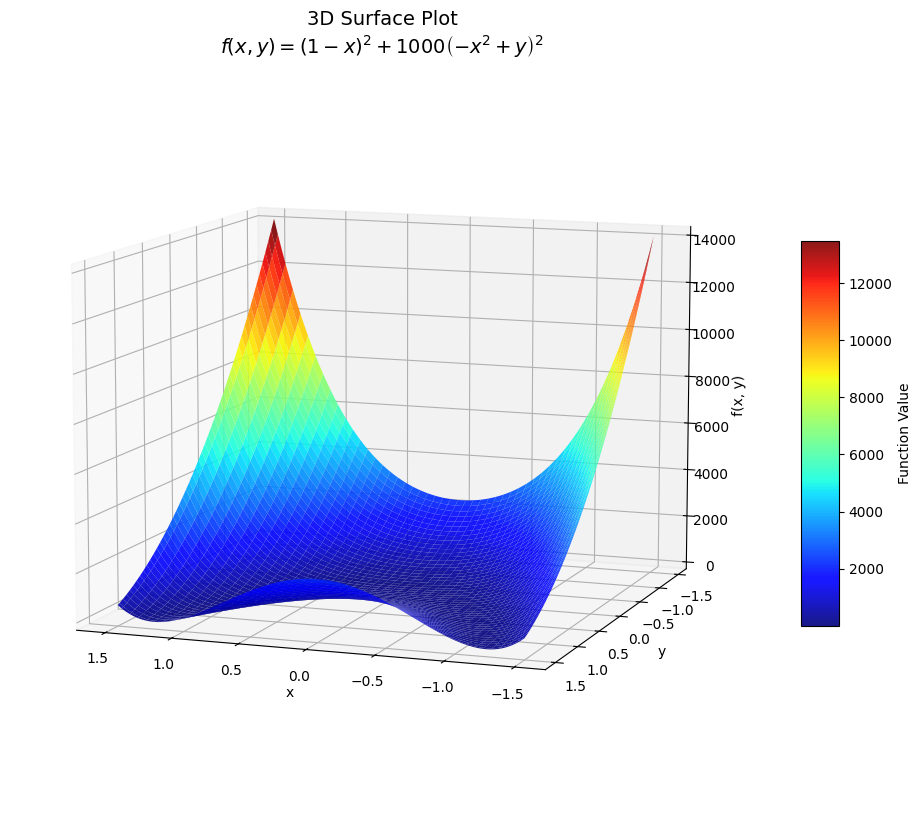

In [17]:
plot_surface(f_func, f, (-1.5, 1.5), (-1.5, 1.5), elev=10, azim=110)

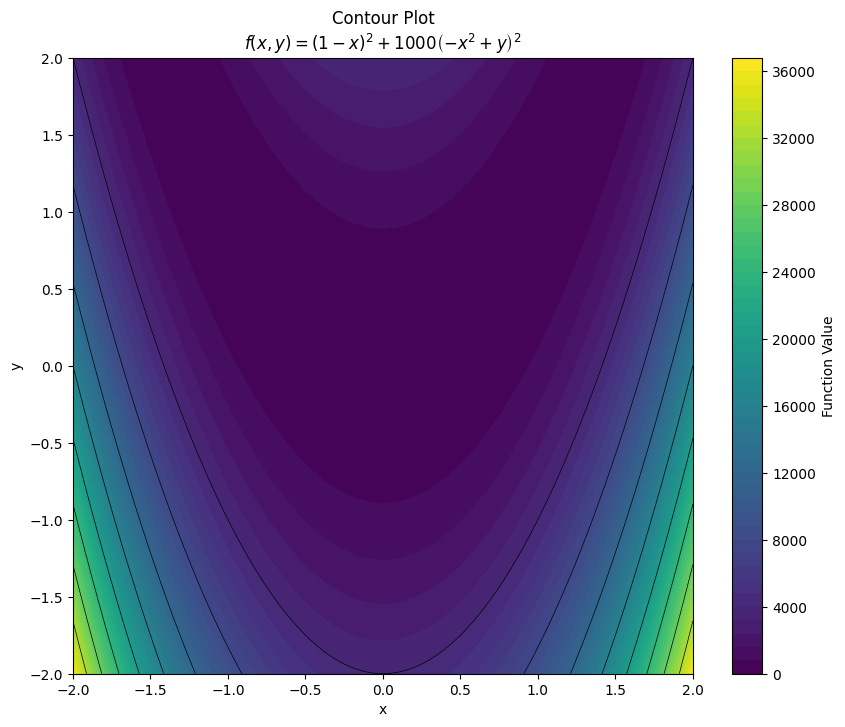

In [18]:
plot_contour(f_func, f, (-2, 2), (-2, 2))

It's hard to choose an appropriate point $\mathbf{x}_0$ from the contour plot

In [19]:
# Initial point as standard start
x0 = [-1.2, 1]

In [20]:
# Test Levenberg-Marquardt
solver_lm = LevenbergMarquardtSolver(f, [x, y], x0)
result_lm = solver_lm.solve(verbose=False)
print("Levenberg-Marquardt Result:")
for key, value in result_lm.items():
    if key != "history":
        print(f"{key}: {value}")

# Test Newton-Raphson
solver_nr = NewtonRaphsonSolver(f, [x, y], x0)
result_nr = solver_nr.solve(verbose=False)
print("\nNewton-Raphson Result:")
for key, value in result_nr.items():
    if key != "history":
        print(f"{key}: {value}")

# Test BFGS
result_bfgs = minimize(f_scipy, x0, method='BFGS', tol=0.5e-6)
print("\nBFGS Result:")
for key in ['success', 'message', 'x', 'fun', 'nit', 'nfev']:
    print(f"{key}: {result_bfgs[key]}")

Levenberg-Marquardt Result:
success: True
reason: Converged within tolerances
x: [1. 1.]
fun: 2.980312659903061e-19
nit: 67
nfev: 68
lambda: 1.3113021850585939e-07

Newton-Raphson Result:
success: True
message: Converged within tolerances
x: [1. 1.]
fun: 0.0
nit: 6
nfev: 7

BFGS Result:
success: True
message: Optimization terminated successfully.
x: [0.9999553  0.99991059]
fun: 1.998444338201607e-09
nit: 64
nfev: 243


Levenberg–Marquardt spends extra iterations transitioning from steepest descent to Newton–Raphson behaviour, especially in flat regions.

\newpage

## McCormick Function

[Simon Fraser University](https://www.sfu.ca/~ssurjano/mccorm.html)

$$
f(x, y) = \sin(x + y) + (x - y)^2 - 1.5x + 2.5y + 1
$$

Sharp transitions between steep and flat regions can mislead the step direction.

In [21]:
# Define the variables
x, y = sp.symbols('x y')
variables = [x, y]

# Define function
f = sp.sin(x + y) + (x - y)**2 -sp.Rational(3, 2)*x + sp.Rational(5, 2)*y + 1

# Lambdify for plotting
f_func = sp.lambdify(variables, f, 'numpy')

# Wrapper to reshape the input for SciPy
def f_scipy(x_array):
    return f_func(*x_array)  # Unpack array into variables

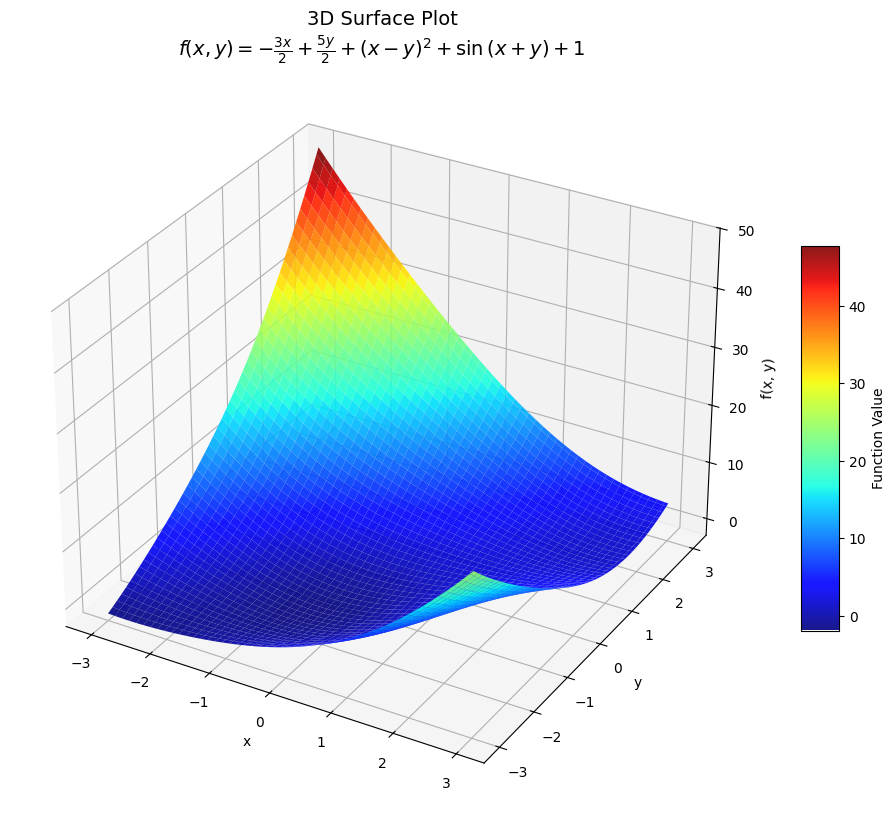

In [22]:
plot_surface(f_func, f, (-3, 3), (-3, 3), elev=30, azim=-60)

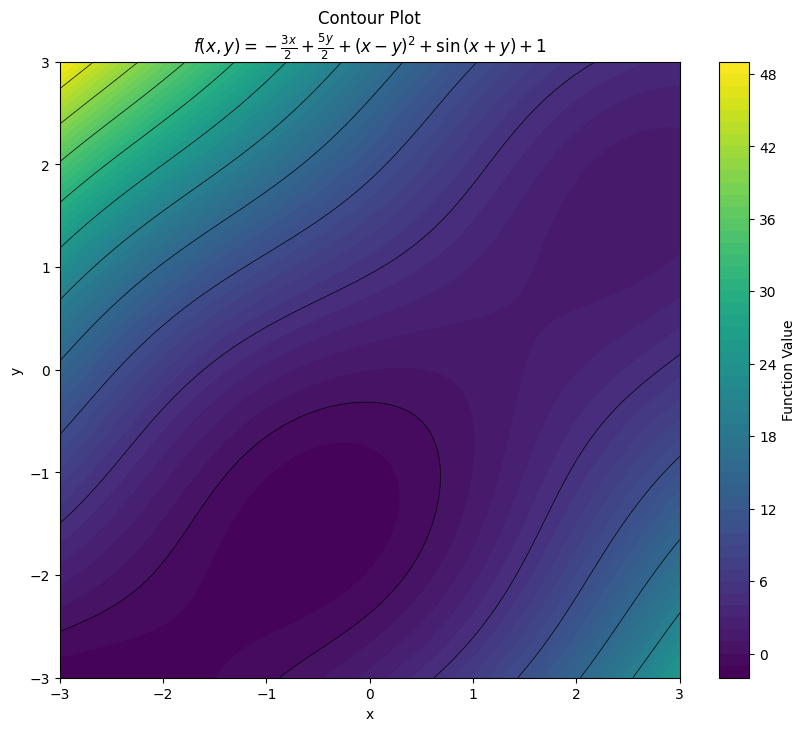

In [23]:
plot_contour(f_func, f, (-3, 3), (-3, 3))

The minimiser of this function is known to be,
$$f(\mathbf{x})=f(-0.54719, -1.54719)=-1.9133$$

In [24]:
# Define a list of points (easy, medium, hard cases)
points = [
    [-0.5, -1.5],  # Easy region
    [1.0, 0.5],    # Medium difficulty
    [1.5, 1.5]     # Hard region
]

In [25]:
# Loop through the points
for point in points:
    print("\n----------------------------")
    print(f"Testing at point: {point}\n")

    # Test Levenberg-Marquardt
    solver_lm = LevenbergMarquardtSolver(f, [x, y], point)
    result_lm = solver_lm.solve(verbose=False)
    print("Levenberg-Marquardt Result:")
    for key, value in result_lm.items():
        if key != "history":
            print(f"{key}: {value}")

    # Test Newton-Raphson
    solver_nr = NewtonRaphsonSolver(f, [x, y], point)
    result_nr = solver_nr.solve(verbose=False)
    print("\nNewton-Raphson Result:")
    for key, value in result_nr.items():
        if key != "history":
            print(f"{key}: {value}")

    # Test BFGS
    result_bfgs = minimize(f_scipy, point, method='BFGS', tol=0.5e-6)
    print("\nBFGS Result:")
    for key in ['success', 'message', 'x', 'fun', 'nit', 'nfev']:
        print(f"{key}: {result_bfgs[key]}")


----------------------------
Testing at point: [-0.5, -1.5]

Levenberg-Marquardt Result:
success: True
reason: Converged within tolerances
x: [-0.54719754 -1.54719754]
fun: -1.9132229549810362
nit: 8
nfev: 9
lambda: 0.004296875

Newton-Raphson Result:
success: True
message: Converged within tolerances
x: [-0.54719755 -1.54719755]
fun: -1.9132229549810367
nit: 3
nfev: 4

BFGS Result:
success: True
message: Optimization terminated successfully.
x: [-0.54719756 -1.54719756]
fun: -1.9132229549810362
nit: 5
nfev: 18

----------------------------
Testing at point: [1.0, 0.5]

Levenberg-Marquardt Result:
success: True
reason: Converged within tolerances
x: [-0.54719755 -1.54719755]
fun: -1.9132229549810367
nit: 9
nfev: 10
lambda: 0.0021484375

Newton-Raphson Result:
success: True
message: Converged within tolerances
x: [-3.6887902 -4.6887902]
fun: -5.054815608570831
nit: 19
nfev: 20

BFGS Result:
success: True
message: Optimization terminated successfully.
x: [-0.54719758 -1.54719755]
fun: -

N-R performed well in the easy case (Point 1) but completely failed in medium and hard cases (Points 2 and 3) due to poor Hessian conditioning.

\newpage

## Beale’s Function

$$
f(x, y) = \left(1.5 - x + xy\right)^2 + \left(2.25 - x + xy^2\right)^2 + \left(2.625 - x + xy^3\right)^2
$$

Highly sensitive to the initial point.

In [26]:
# Define the variables
x, y = sp.symbols('x y')
variables = [x, y]

# Define function
f = ((sp.Rational(3, 2) - x + x*y)**2 + (sp.Rational(9, 4) - x + x*y**2)**2
        + (sp.Rational(21, 8) - x + x*y**3)**2)

# Lambdify for plotting
f_func = sp.lambdify(variables, f, 'numpy')

# Wrapper to reshape the input for SciPy
def f_scipy(x_array):
    return f_func(*x_array)  # Unpack array into variables

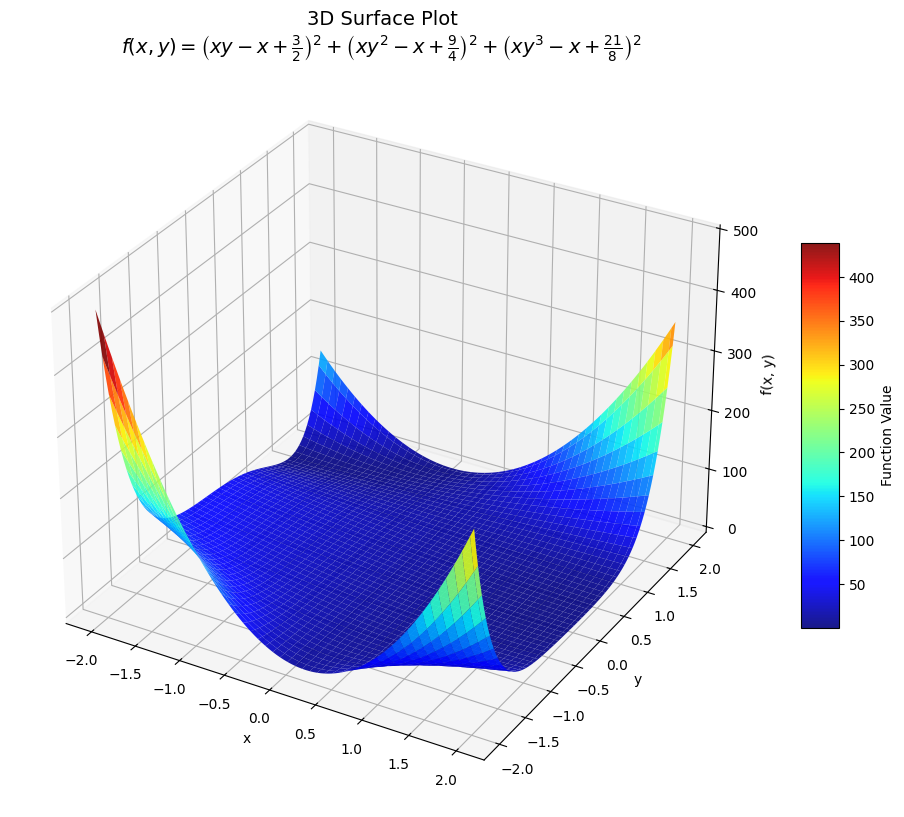

In [27]:
plot_surface(f_func, f, (-2, 2), (-2, 2), elev=30, azim=-60)

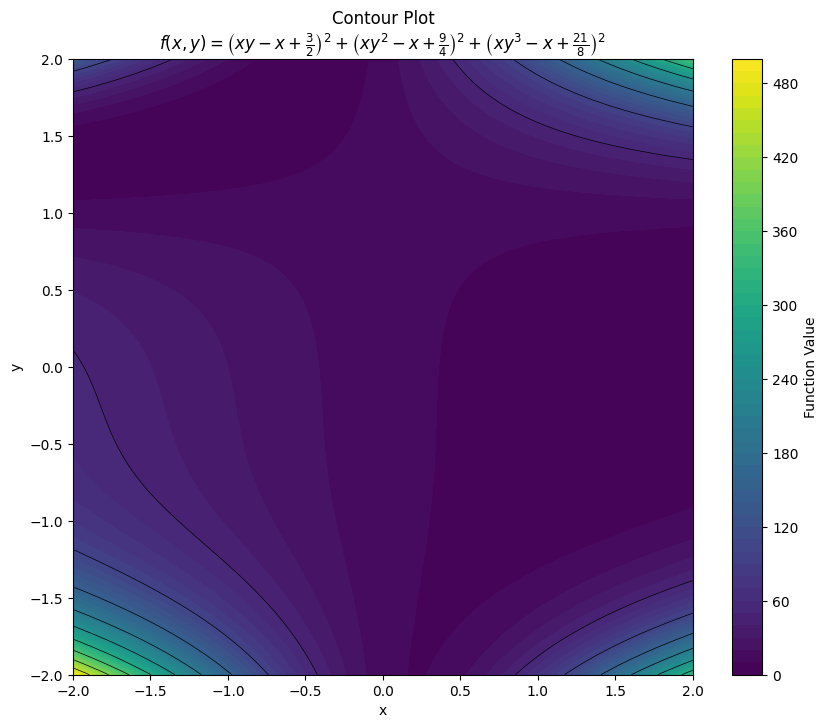

In [28]:
plot_contour(f_func, f, (-2, 2), (-2, 2))

The minimiser of this function is known to be,
$$f(\mathbf{x})=f(3, 0.5)=0$$

In [29]:
# Define a list of points (easy, medium, hard cases)
points = [
    [3, 0.5],  # Easy region
    [0, -1],    # Medium difficulty
    [-2, 2]     # Hard region
]

In [30]:
# Loop through the points
for i, point in enumerate(points):
    print("\n----------------------------")
    print(f"Testing at point: {point}\n")

    # Test Levenberg-Marquardt
    solver_lm = LevenbergMarquardtSolver(f, [x, y], point)
    result_lm = solver_lm.solve(verbose=False)
    print("Levenberg-Marquardt Result:")
    for key, value in result_lm.items():
        if key != "history":
            print(f"{key}: {value}")
    if i == 1:
        x_min = result_lm['x']

    # Test Newton-Raphson
    solver_nr = NewtonRaphsonSolver(f, [x, y], point)
    result_nr = solver_nr.solve(verbose=False)
    print("\nNewton-Raphson Result:")
    for key, value in result_nr.items():
        if key != "history":
            print(f"{key}: {value}")

    # Test BFGS
    result_bfgs = minimize(f_scipy, point, method='BFGS', tol=0.5e-6)
    print("\nBFGS Result:")
    for key in ['success', 'message', 'x', 'fun', 'nit', 'nfev']:
        print(f"{key}: {result_bfgs[key]}")


----------------------------
Testing at point: [3, 0.5]

Levenberg-Marquardt Result:
success: False
reason: Maximum iterations reached
x: [3.  0.5]
fun: 0.0
nit: 100
nfev: 101
lambda: 1.3944156602510525e+30

Newton-Raphson Result:
success: True
message: Converged within tolerances
x: [3.  0.5]
fun: 0.0
nit: 1
nfev: 2

BFGS Result:
success: True
message: Optimization terminated successfully.
x: [3.  0.5]
fun: 0.0
nit: 0
nfev: 3

----------------------------
Testing at point: [0, -1]

Levenberg-Marquardt Result:
success: True
reason: Converged within tolerances
x: [2.99999999 0.5       ]
fun: 8.421828674538515e-18
nit: 15
nfev: 16
lambda: 3.35693359375e-05

Newton-Raphson Result:
success: False
message: Maximum iterations reached
x: [186.27908962   0.99465405]
fun: 0.443801145216386
nit: 100
nfev: 101

BFGS Result:
success: True
message: Optimization terminated successfully.
x: [2.9999997  0.49999991]
fun: 1.705228817073453e-14
nit: 15
nfev: 54

----------------------------
Testing at p

Plotting `x` from Levenberg-Marquardt method

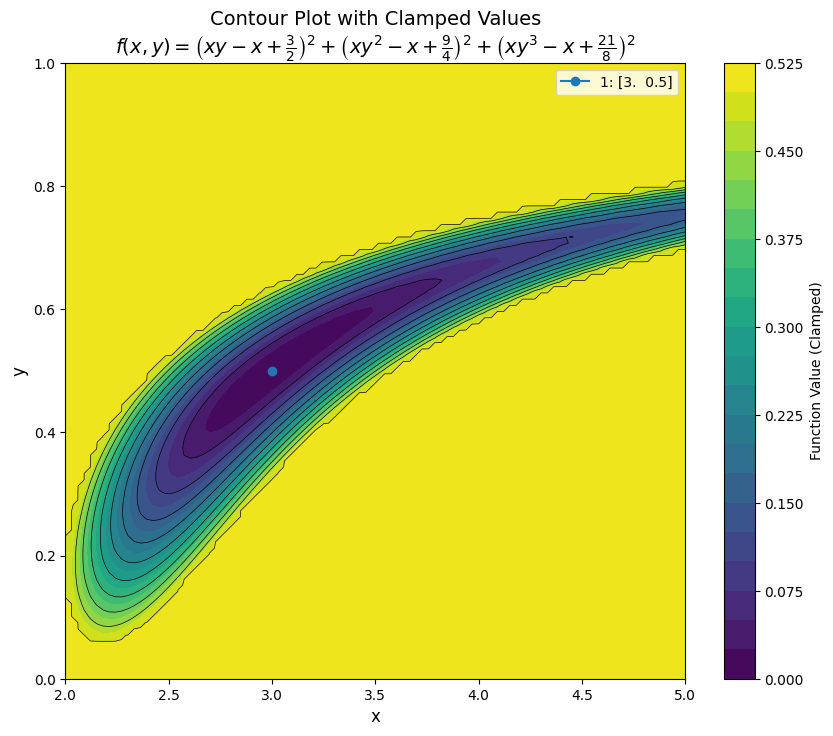

In [31]:
solver_lm = LevenbergMarquardtSolver(f, [x, y], [0, -1])
result_lm = solver_lm.solve(verbose=False)
x_min = result_lm['x']
plot_clamped_contour(f_func, f, (2, 5), (0, 1), minimisers=x_min)

\newpage

## Goldstein-Price Function

$$
f(x, y) = \left[ 1 + \left( x + y + 1 \right)^2 \left( 19 - 14x + 3x^2 - 14y + 6xy + 3y^2 \right) \right] \cdot
\left[ 30 + \left( 2x - 3y \right)^2 \left( 18 - 32x + 12x^2 + 48y - 36xy + 27y^2 \right) \right]
$$

It has a highly complex surface with many local minima, making it a challenging test case for optimisation algorithms.


In [32]:
# Define the variables
x, y = sp.symbols('x y')
variables = [x, y]

# Define function
f = (
    (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) *
    (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
)
# Lambdify for plotting
f_func = sp.lambdify([x, y], f, 'numpy')

# Wrapper to reshape the input for SciPy
def f_scipy(x_array):
    return f_func(*x_array)  # Unpack array into variables

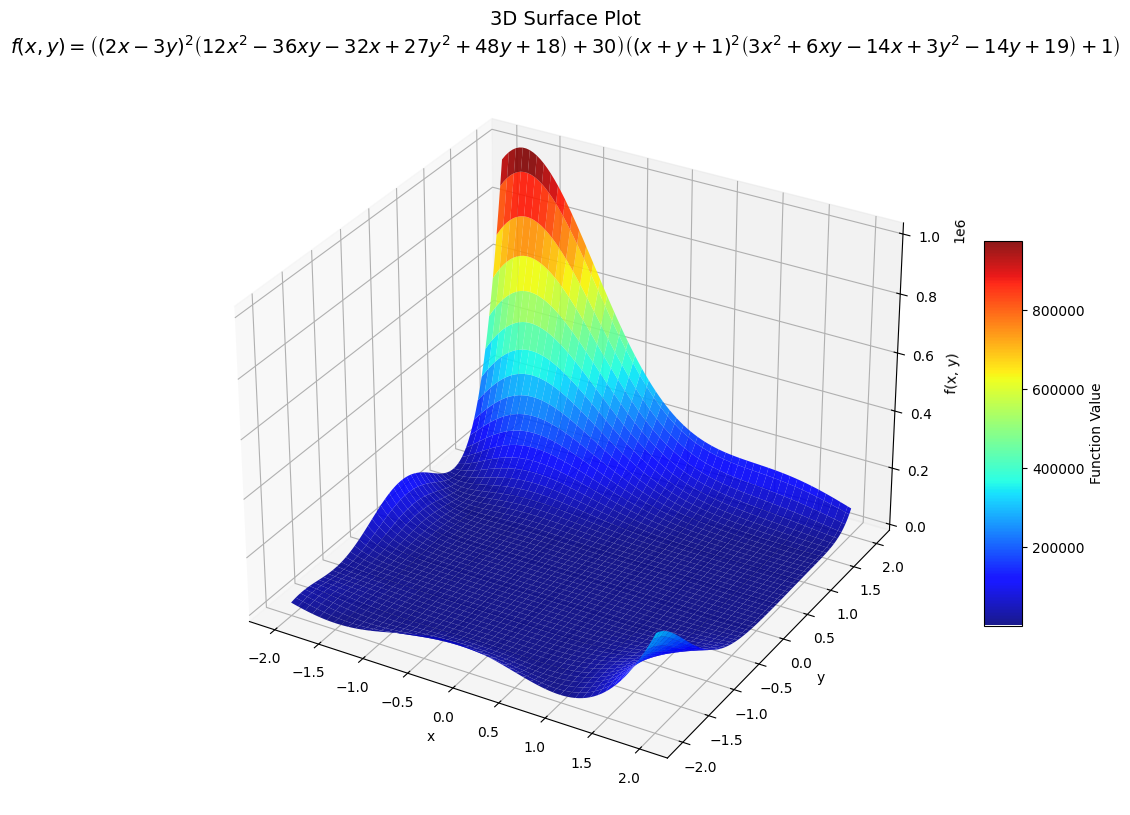

In [33]:
plot_surface(f_func, f, x_range=(-2, 2), y_range=(-2, 2), elev=30, azim=-60)

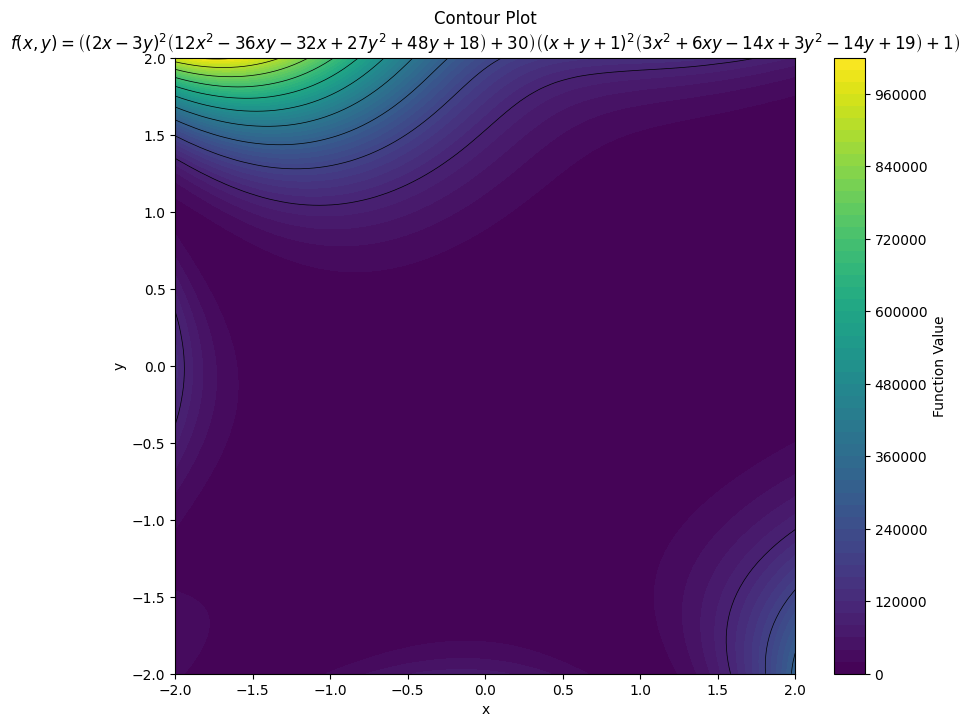

In [34]:
plot_contour(f_func, f, (-2, 2), (-2, 2))

It's hard to know what would be a suitable starting point from the plots...

The global minimum is known to be $f(\mathbf{x})=(0, -1)=3$

Despite having only one minimum, the function’s surface is highly complex, with steep regions, plateaus, and large curvature differences.

In [35]:
# Choose a 'medium hard' initial point
x0 = [0.5, -0.5]

In [36]:
# Test Levenberg-Marquardt
solver_lm = LevenbergMarquardtSolver(f, [x, y], x0)
result_lm = solver_lm.solve(verbose=False)
print("Levenberg-Marquardt Result:")
for key, value in result_lm.items():
    if key != "history":
        print(f"{key}: {value}")

# Test Newton-Raphson
solver_nr = NewtonRaphsonSolver(f, [x, y], x0)
result_nr = solver_nr.solve(verbose=False)
print("\nNewton-Raphson Result:")
for key, value in result_nr.items():
    if key != "history":
        print(f"{key}: {value}")

# Test BFGS
result_bfgs = minimize(f_scipy, x0, method='BFGS', tol=0.5e-6)
print("\nBFGS Result:")
for key in ['success', 'message', 'x', 'fun', 'nit', 'nfev']:
    print(f"{key}: {result_bfgs[key]}")

Levenberg-Marquardt Result:
success: True
reason: Converged within tolerances
x: [-7.38336855e-09 -1.00000001e+00]
fun: 3.000000000000029
nit: 10
nfev: 11
lambda: 0.00107421875

Newton-Raphson Result:
success: True
message: Converged within tolerances
x: [ 1.12861014e-16 -1.00000000e+00]
fun: 3.0
nit: 43
nfev: 44

BFGS Result:
success: False
message: Desired error not necessarily achieved due to precision loss.
x: [-9.71184783e-09 -1.00000001e+00]
fun: 2.9999999999999885
nit: 14
nfev: 155


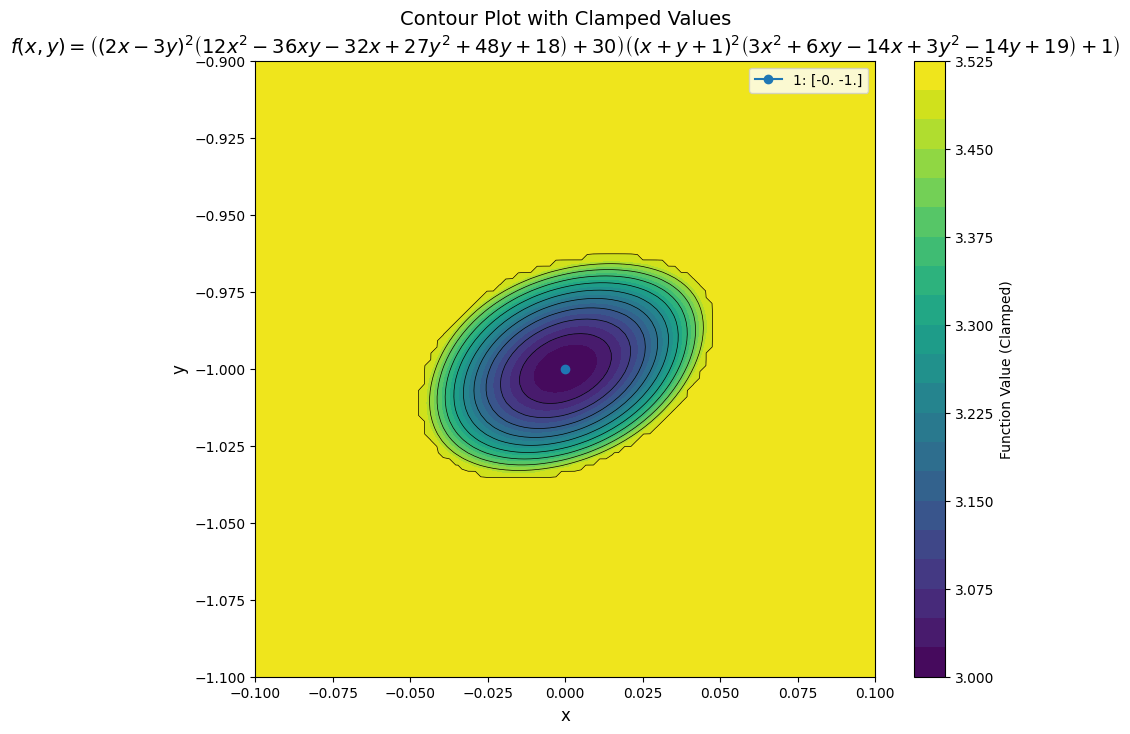

In [37]:
x_min = result_lm['x']
plot_clamped_contour(f_func, f, (-0.1, 0.1), (-1.1, -0.9) , minimisers=x_min)

\newpage

## Rastrigin Function

[Wikipedia](https://en.wikipedia.org/wiki/Rastrigin_function)

Finding the minimum of this function is a fairly difficult problem due to its large search space and its large number of local minima.

In [38]:
# Define the Rastrigin function as a Sympy Function
class RastriginFunction(sp.Function):
    @classmethod
    def eval(cls, n, A, *args):
        # Compute the Rastrigin function for n dimensions
        return A * n + sum(xi**2 - A * sp.cos(2 * sp.pi * xi) for xi in args)

# Instantiate for n = 2
n = 2
A = 10
x1, x2 = sp.symbols('x1 x2')  # Define the variables for n = 2
variables = [x1, x2]

# Define the Rastrigin function
f = RastriginFunction(n, A, x1, x2)

# Lambdify for plotting
f_func = sp.lambdify(variables, f, 'numpy')

# Wrapper to reshape the input for SciPy
def f_scipy(x_array):
    return f_func(*x_array)  # Unpack array into variables

In [39]:
print(f"This is the maximum value for n=2:\nf = {f_func(4.52299366, 4.52299366)}")

This is the maximum value for n=2:
f = 80.70658038767792


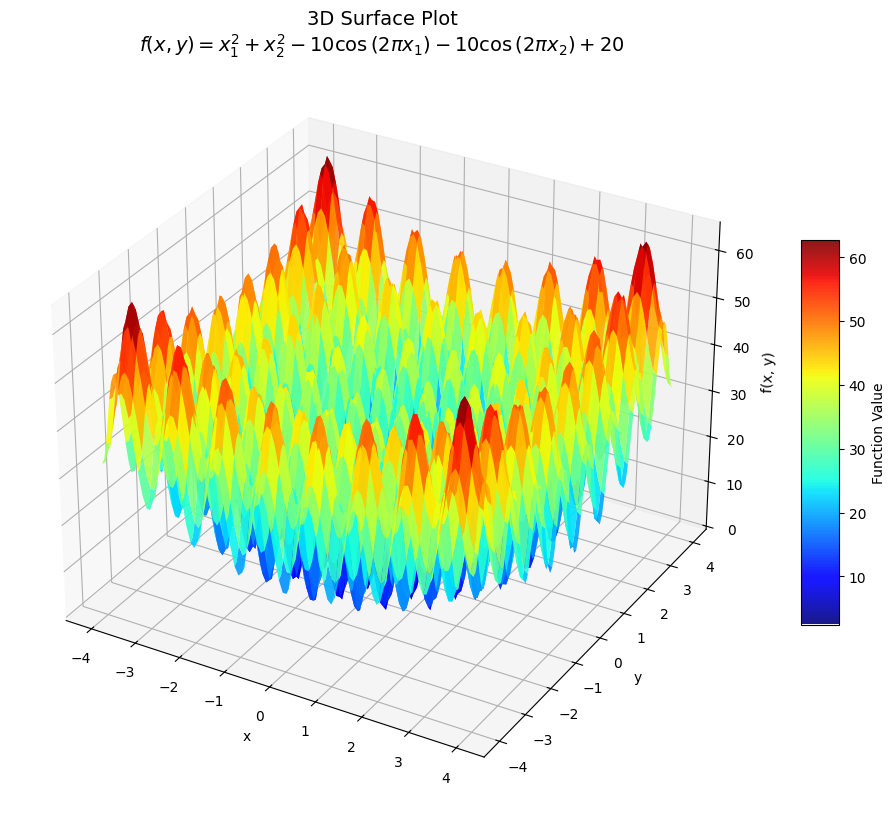

In [40]:
plot_surface(f_func, f, x_range=(-4, 4), y_range=(-4, 4), elev=30, azim=-60)

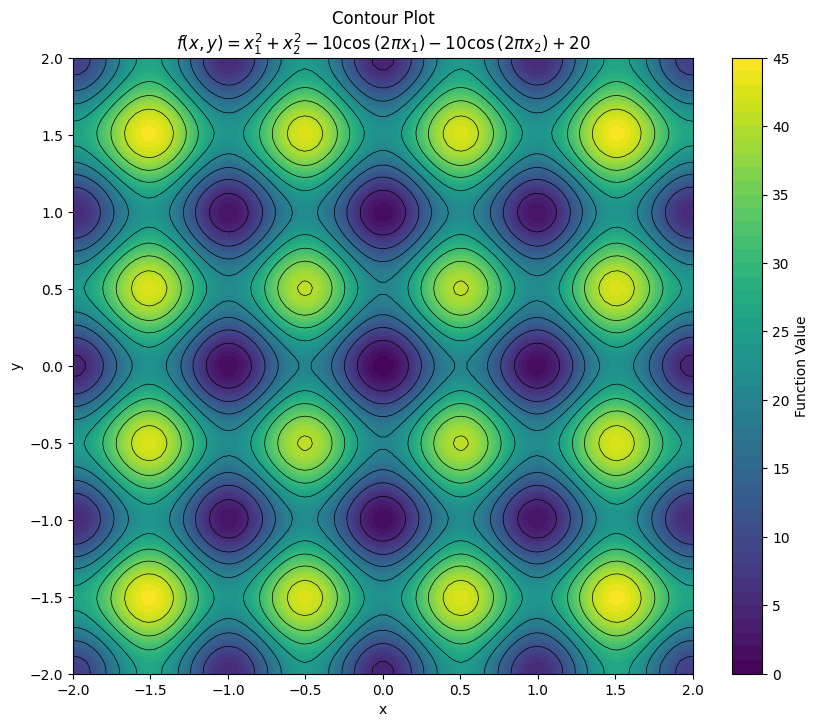

In [41]:
plot_contour(f_func, f, (-2, 2), (-2, 2))

The global minimum is at $\mathbf{x}=\mathbf{0}$ where $f(\mathbf{x})=0$

In [42]:
# Choosing a peak initial point
x0 = [0.5, 0.5]

In [43]:
# Test Levenberg-Marquardt
solver_lm = LevenbergMarquardtSolver(f, [x1, x2], x0)
result_lm = solver_lm.solve(verbose=False)
print("Levenberg-Marquardt Result:")
for key, value in result_lm.items():
    if key != "history":
        print(f"{key}: {value}")

# Test Newton-Raphson
solver_nr = NewtonRaphsonSolver(f, [x1, x2], x0)
result_nr = solver_nr.solve(verbose=False)
print("\nNewton-Raphson Result:")
for key, value in result_nr.items():
    if key != "history":
        print(f"{key}: {value}")

# Test BFGS
result_bfgs = minimize(f_scipy, x0, method='BFGS', tol=0.5e-6)
print("\nBFGS Result:")
for key in ['success', 'message', 'x', 'fun', 'nit', 'nfev']:
    print(f"{key}: {result_bfgs[key]}")

Levenberg-Marquardt Result:
success: True
reason: Converged within tolerances
x: [-1.77210488e-10 -1.77210488e-10]
fun: 0.0
nit: 11
nfev: 12
lambda: 0.004296875

Newton-Raphson Result:
success: True
message: Converged within tolerances
x: [7.95923374 7.95923374]
fun: 127.35131127294895
nit: 11
nfev: 12

BFGS Result:
success: True
message: Optimization terminated successfully.
x: [-7.69975016e-09 -7.69975016e-09]
fun: 2.4868995751603507e-14
nit: 3
nfev: 30


Again, N-R has located a saddle point as the minimum. L-M has succeeded albeit from a 'close enough' initial point. This underlines the necessity of a global optimisation algorithm to find the global minimum.

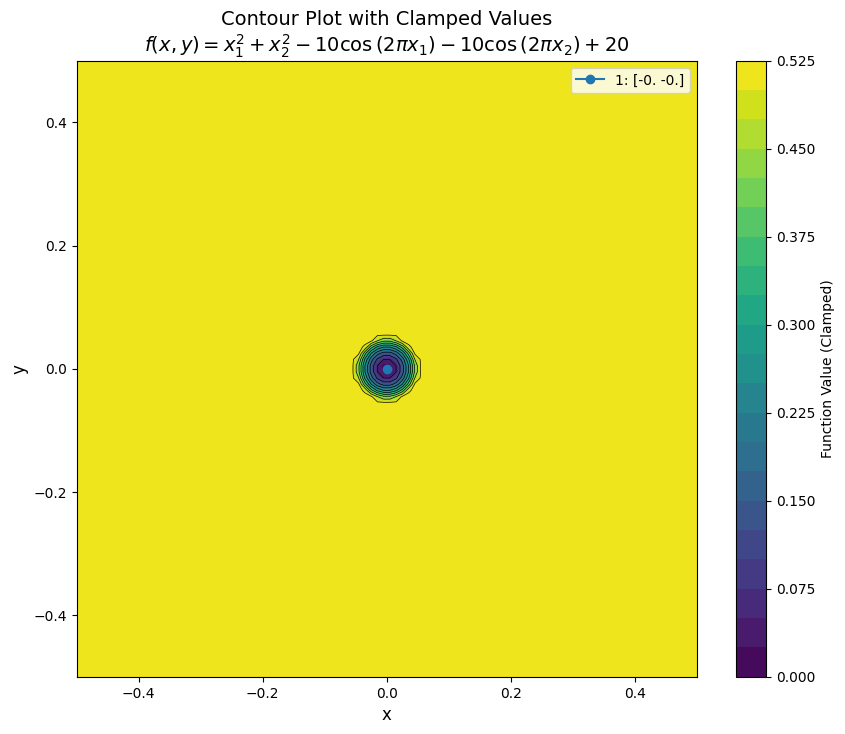

In [44]:
x_min = result_lm['x']
plot_clamped_contour(f_func, f, (-0.5, 0.5), (-0.5, 0.5) , minimisers=x_min)

----

More to consider below:

[Interesting functions to optimise in Machine Learning](https://www.mdrk.io/interesting-functions-to-optimize/)